# Conditional DCGAN for Q2 and Q3

## Imports

In [0]:
import os, time, random,itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import pdb
from google.colab import files

## Load data

In [2]:
tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
X_train, y_train_cgan           = mnist.train.images, mnist.train.labels

x_train = (X_train - 0.5) / 0.5  



mnist_classifier = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist_classifier.train.images, mnist_classifier.train.labels
X_validation, y_validation = mnist_classifier.validation.images, mnist_classifier.validation.labels
X_test, y_test             = mnist_classifier.test.images, mnist_classifier.test.labels

 

IMAGE_SIZE = 28
onehot = np.eye(10)

def leaky_relu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Classifier

In [3]:
#Classifier parameters
EPOCHS = 20
BATCH_SIZE = 128
Rate_C = 0.005

#Placeholder
x_Classfier = tf.placeholder(tf.float32, (None, 32, 32, 1))
y_Classfier = tf.placeholder(tf.int32, (None))
one_hot_y_Classfier = tf.one_hot(y_Classfier, 10)

#zero padding
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

#classifier network
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Input: BATCH_SIZEx32x32x1
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6], mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    
    # Activation. max(0,conv1)
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    # [Batch,Height,Width,Depth]
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b
    
    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    
    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits
  
# Loss function
logits = LeNet(x_Classfier)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y_Classfier, logits=logits)  
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=Rate_C)
# AdagradOptimizer, or MomentumOptimizer
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Function to evaluate the model

In [0]:
predictions_operation = tf.argmax(tf.nn.softmax(logits), 1)
correct_prediction = tf.equal(predictions_operation, tf.argmax(one_hot_y_Classfier, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    all_predictions = []
    # i = 0:BATCH_SIZE:num_examples
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, predictions = sess.run([accuracy_operation, predictions_operation], feed_dict={x_Classfier: batch_x, y_Classfier: batch_y})
        
        all_predictions = np.hstack((all_predictions, predictions))
        total_accuracy += (accuracy * len(batch_x))
    all_predictions = np.array(all_predictions)
    return total_accuracy / num_examples, all_predictions

### Placeholder

In [0]:
x = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 1))
noise = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
labels = tf.placeholder(tf.float32, shape=(None, 1, 1, 10))
real = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 10))
Training = tf.placeholder(dtype=tf.bool)
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')

## Generator

In [0]:
def Generator(x, labels,keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)

        concat = tf.concat([x, labels], 3)

        out_1 = tf.layers.conv2d_transpose(concat, 256, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)

        out_2 = tf.layers.conv2d_transpose(out_1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)

        out_3 = tf.layers.conv2d_transpose(out_2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_3 = tf.nn.tanh(out_3)
        return out_3

## Discriminator

In [0]:
def Discriminator(x, real,keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):

        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)

        concat = tf.concat([x, real], 3)

        out_1 = tf.layers.conv2d(concat, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.layers.batch_normalization(out_1, training=Training)#batch norm
        out_1 = leaky_relu(out_1, 0.2)

        out_2 = tf.layers.conv2d(out_1, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.layers.batch_normalization(out_2, training=Training)#batch norm
        out_2 = leaky_relu(out_2, 0.2)

        out_3 = tf.layers.conv2d(out_2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W)
        logits = tf.nn.sigmoid(out_3)
        return logits, out_3

## Set cDCGAN

In [0]:
EPOCH = 20
BATCH_SIZE = 128
keep_prob_train = 0.6
BETAL = 0.5
lr = tf.constant(0.0002)

## Loss Function

In [9]:
# Generate images
G_noise = Generator(noise, labels, Training)
# D
D_real, D_real_logits = Discriminator(x, real, Training)
D_fake, D_fake_logits = Discriminator(G_noise, real, Training, reuse=True)
# D real loss
Dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones([BATCH_SIZE, 1, 1, 1])))
# D generated image loss
Dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([BATCH_SIZE, 1, 1, 1])))
# D total loss
Dis_loss = Dis_loss_real + Dis_loss_fake
# G loss
Gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([BATCH_SIZE, 1, 1, 1])))
# get all variables
tf_vars = tf.trainable_variables()
Dis_vars = [var for var in tf_vars if var.name.startswith('Discriminator')]
Gen_vars = [var for var in tf_vars if var.name.startswith('Generator')]
# optimise
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optim = tf.train.AdamOptimizer(lr, beta1=BETAL)
    D_optim = optim.minimize(Dis_loss, var_list=Dis_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=BETAL).minimize(Gen_loss, var_list=Gen_vars)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d instead.


## Training Pipeline

In [10]:
saver = tf.train.Saver()

n_sample = 1000
y_generated = np.zeros(shape=[10*n_sample,1,1,10])
y_ = np.zeros(shape=[10*n_sample])

for i in range(10):   
    y_generated[n_sample*i:n_sample*(i+1),:,:, i] = 1
    y_[n_sample*i:n_sample*(i+1)] = i
    
num_examples = len(x_train) 
k = num_examples % BATCH_SIZE
num_examples_gan = num_examples - k

G_loss = []
D_loss = []

D_r = []
D_f = []

Acc_DCGAN = []
Acc_test = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training Classifier")  
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
         
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x_Classfier: batch_x, y_Classfier: batch_y})
            
        validation_accuracy, _ = evaluate(X_validation, y_validation)
        if ((i+1)%10 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
            
            
    print("Training CDCGAN")    
    for i in range(EPOCH):  
        start = time.time()        
        x_train, y_train_cgan = shuffle(x_train, y_train_cgan)    
        for offset in range(0, num_examples_gan, BATCH_SIZE):
            train_d = True
            train_g = True                        
            end = offset + BATCH_SIZE
            batch_x = x_train[offset:end] 
            batch_y = y_train_cgan[offset:end] 
            
            label_ = batch_y.reshape([BATCH_SIZE, 1, 1, 10])
            real_ = label_ * np.ones([BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 10])
            noise_ = np.random.normal(0, 1, (BATCH_SIZE, 1, 1, 100))
                        
            #calculate loss
            d_ls = sess.run(Dis_loss,{noise: noise_, x: batch_x, real: real_, labels: label_, Training: False})
            g_ls = sess.run(Gen_loss,{noise: noise_, x: batch_x, real: real_, labels: label_, Training: False})
                                    
            #Gobal loss          
            d_r = sess.run([D_real], {x: batch_x, real: real_, labels: label_, Training: False})  
            d_f = sess.run([D_fake], {noise: noise_, real: real_, labels: label_, Training: False}) 
            
            d_r = np.mean(d_r)
            d_f = np.mean(d_f)
            #break
            D_r.append(d_r)
            D_f.append(d_f)
                  
            D_loss.append(d_ls)
            G_loss.append(g_ls)
            
            if g_ls * 1.5 < d_ls:
                train_g = False
                pass
            if d_ls * 2 < g_ls:
                train_d = False
                pass
            
            #Update D 
            if train_d:
                sess.run(D_optim, {x: batch_x, noise: noise_,keep_prob: keep_prob_train,real: real_, labels: label_,Training: True})
            
            #Update G
            if train_g:
                sess.run(G_optim, {noise: noise_, x:batch_x,keep_prob: keep_prob_train,real: real_, labels: label_, Training: True})
                
            
            
        # Calculate accuracy
        n =  np.random.normal(0, 1, (10*n_sample, 1, 1, 100))
        samples = sess.run(G_noise, feed_dict={noise:n, labels:y_generated, Training:False})   
        samples = samples*2 + 0.5
        x_ = np.pad(samples, ((0,0),(2,2),(2,2),(0,0)), 'constant')
        
        generated_accuracy, _ = evaluate(x_, y_)
        test_accuracy, _ = evaluate(X_test, y_test)
        Acc_DCGAN.append(generated_accuracy)
        Acc_test.append(test_accuracy)
        
        end = time.time()
        elapsed = end - start    
        #break
        if ((i+1)%2 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print("G_loss = {:.3f}  D_loss = {:.3f}  Accuracy = {:.3f}  TIme used = {:.3f}".format(g_ls, d_ls,generated_accuracy,elapsed))
            print()     

            
    saver.save(sess, './lenet')
    print("Model saved")

Training Classifier
EPOCH 1 ...
Validation Accuracy = 0.977

EPOCH 10 ...
Validation Accuracy = 0.981

EPOCH 20 ...
Validation Accuracy = 0.986

Training CDCGAN
EPOCH 1 ...
G_loss = 0.597  D_loss = 1.126  Accuracy = 0.489  TIme used = 125.329

EPOCH 2 ...
G_loss = 1.910  D_loss = 0.780  Accuracy = 0.622  TIme used = 107.119

EPOCH 4 ...
G_loss = 1.109  D_loss = 0.907  Accuracy = 0.822  TIme used = 127.540

EPOCH 6 ...
G_loss = 0.924  D_loss = 0.976  Accuracy = 0.875  TIme used = 126.708

EPOCH 8 ...
G_loss = 0.870  D_loss = 0.980  Accuracy = 0.892  TIme used = 126.058

EPOCH 10 ...
G_loss = 0.831  D_loss = 1.055  Accuracy = 0.904  TIme used = 126.965

EPOCH 12 ...
G_loss = 0.530  D_loss = 1.283  Accuracy = 0.904  TIme used = 126.834

EPOCH 14 ...
G_loss = 0.941  D_loss = 1.040  Accuracy = 0.925  TIme used = 127.795

EPOCH 16 ...
G_loss = 0.775  D_loss = 1.060  Accuracy = 0.922  TIme used = 127.918

EPOCH 18 ...
G_loss = 1.671  D_loss = 0.933  Accuracy = 0.935  TIme used = 128.487

EPOC

## Inception score and Visualization

Last EPOCH :
Accuracy of Generated Images = 0.932
Accuracy of Testing Set = 0.987


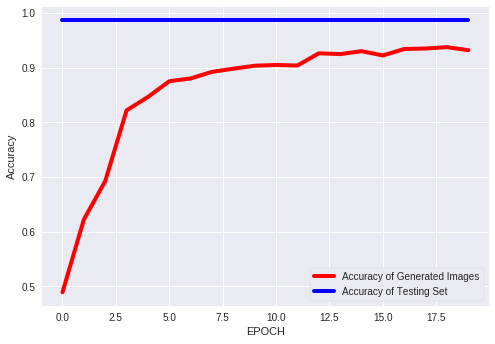

In [11]:
print("Last EPOCH :")   
print("Accuracy of Generated Images = {:.3f}".format(generated_accuracy))   
print("Accuracy of Testing Set = {:.3f}".format(test_accuracy))

N = len(Acc_DCGAN)
index = np.arange(0,N,1)

f_d = plt.figure(1)
plt.plot(index, Acc_DCGAN, 'r',linewidth=4,label='Accuracy of Generated Images')
plt.plot(index, Acc_test, 'b',linewidth=4, label='Accuracy of Testing Set')
plt.xlabel("EPOCH")
plt.ylabel("Accuracy")
plt.legend(framealpha=1, frameon=True)
plt.show()

f_d.savefig('Accuracy.png', dpi=600)
files.download('Accuracy.png')

## D real and fake loss

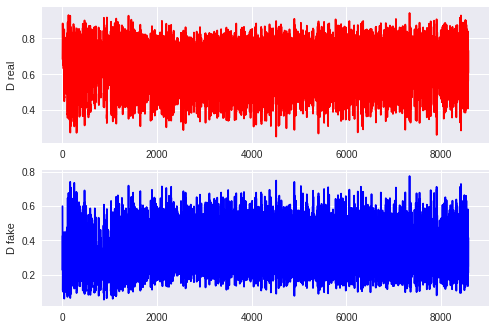

In [12]:
N = len(D_r)
#D_r = np.array(D_r)
index = np.arange(0,N,1)
#pdb.set_trace()
f_d = plt.figure(1)
fig = plt.subplot(211)
plt.plot(index, D_r, 'r')
plt.ylabel("D real")

plt.subplot(212)
plt.plot(index, D_f, 'b')
plt.ylabel("D fake")
plt.show()

f_d.savefig('Real and fake Loss.png', dpi=600)

files.download('Real and fake Loss.png')

## Plot Loss

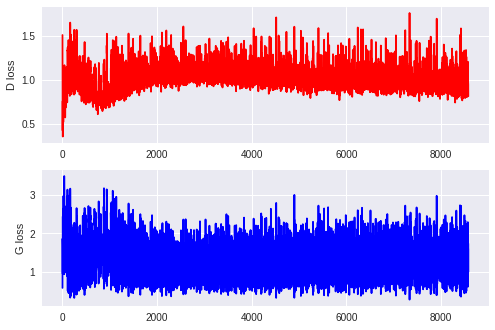

In [13]:
N = len(D_loss)
index = np.arange(0,N,1)

f = plt.figure(1)
fig = plt.subplot(211)
plt.plot(index, D_loss, 'r')
plt.ylabel("D loss")

plt.subplot(212)
plt.plot(index, G_loss, 'b')
plt.ylabel("G loss")
plt.show()

f.savefig('Loss.png', dpi=600)

files.download('Loss.png')

## Visualization

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet


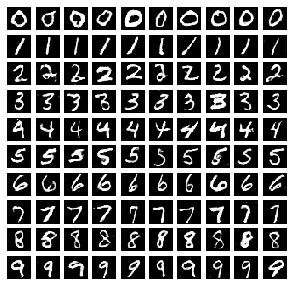

In [14]:
def show_result(test_images, show = True, save = True):
    size_figure_grid = 10
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
    for k in range(10*10):
        i = k // 10
        j = k % 10
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
        
    if show:
        plt.show()
    else:
        plt.close()
    if save:    
        fig.savefig('G images.png', dpi=600)
        files.download('G images.png')
        
        
noise_ = np.random.normal(0, 1, (100, 1, 1, 100))
fixed_label_ = np.zeros((10, 1))

for i in range(9):
    temp = np.ones((10, 1)) + i
    fixed_label_ = np.concatenate([fixed_label_, temp], 0)
fixed_label_ = onehot[fixed_label_.astype(np.int32)].reshape((100, 1, 1, 10))


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    test_images = sess.run(G_noise, {noise: noise_, labels: fixed_label_, Training: False})


show_result(test_images)

## Another visualization

INFO:tensorflow:Restoring parameters from ./lenet


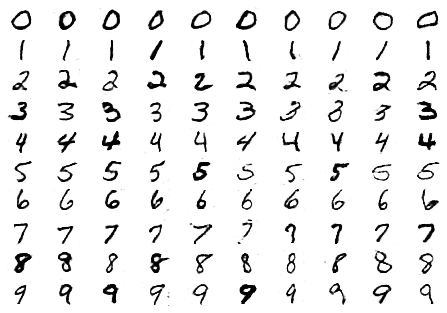

In [15]:
def plot_images(images,save = True):
    assert len(images) == 100
    img_shape = (28, 28)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(10, 10)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
                # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
    if save:    
        fig.savefig('G images_white.png', dpi=600)
        files.download('G images_white.png') 
 

n = np.random.normal(0.0, 1.0, [100,1,1,100]).astype(np.float32) 
fixed_label_ = np.zeros((10, 1))

for i in range(9):
    temp = np.ones((10, 1)) + i
    fixed_label_ = np.concatenate([fixed_label_, temp], 0)
fixed_label_ = onehot[fixed_label_.astype(np.int32)].reshape((100, 1, 1, 10))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))       
    images = sess.run(G_noise, {noise: n, labels: fixed_label_, Training: False})  
    
plot_images(images) 

# Back up

In [0]:
'''
n =  np.random.normal(0, 1, (10*n_sample, 1, 1, 100))
n_sample = 1000
y_generated = np.zeros(shape=[10*n_sample,1,1,10])
y_ = np.zeros(shape=[10*n_sample])

for i in range(10):   
    y_generated[n_sample*i:n_sample*(i+1),:,:, i] = 1
    y_[n_sample*i:n_sample*(i+1)] = i


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    samples = sess.run(G_noise, feed_dict={noise:n, labels:y_generated, Training:False})
    samples = samples*2 + 0.5
    x_ = np.pad(samples, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
    generated_accuracy, generated_predictions = evaluate(x_, y_)
    print("Accuracy of Generated Images = {:.3f}".format(generated_accuracy))
    
    test_accuracy, test_predictions = evaluate(X_test, y_test)
    print("Accuracy of Testing Set = {:.3f}".format(test_accuracy))
'''

INFO:tensorflow:Restoring parameters from ./lenet
Accuracy of Generated Images = 0.437
Accuracy of Testing Set = 0.990
